<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

### CBPF - Centro Brasileiro de Pesquisas Físicas

# Aula 3 - Professor: Clécio R Debom


# Image Segmentation


This notebook will illustrate the basics manipulation and segmentation methods.

**Contact:** debom@cbpf.br</font>
/
<a href="www.clearnightsrthebest.com">clearnightsrthebest.com</a>

<font size="2">

Please do not remove this disclaimer.</font>

# Pre-requirements

Download the file catalog from page 

In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from keras.preprocessing.image import array_to_img
from skimage.io import imread, imshow
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import square, disk
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
import warnings
warnings.filterwarnings("ignore")

2021-11-28 12:22:06.650725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joao/.local/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-28 12:22:06.650777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Info Data Image Challenge

In [7]:
dirpath = "./"
CHL = ["H","J","Y"]
C = ["green", "orange", "blue"]
ID = 200001
#mkdir ./

# Download Fits

In [5]:

!wget -O ./imageEUC_H-200001.fits "https://www.dropbox.com/s/ld3jd8ke6sxe6yp/imageEUC_H-200001.fits?dl=1"
!wget -O ./imageEUC_Y-200001.fits "https://www.dropbox.com/s/xwm2vtezmglis35/imageEUC_J-200001.fits?dl=1"
!wget -O ./imageEUC_J-200001.fits "https://www.dropbox.com/s/xwm2vtezmglis35/imageEUC_J-200001.fits?dl=1"

!ls ./


--2021-11-28 12:23:22--  https://www.dropbox.com/s/ld3jd8ke6sxe6yp/imageEUC_H-200001.fits?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:601d:18::a27d:512, 162.125.5.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:601d:18::a27d:512|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/ld3jd8ke6sxe6yp/imageEUC_H-200001.fits [following]
--2021-11-28 12:23:22--  https://www.dropbox.com/s/dl/ld3jd8ke6sxe6yp/imageEUC_H-200001.fits
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf89b7332c21222c0797c7ba346.dl.dropboxusercontent.com/cd/0/get/Ba3k1aEqEOYmCbE5lI9m6t9XXNf2CyRdqUoi3n9ra0IXlGVkVfCxnKInWyGbmmAMq8gkGeWVuZR8ExLuTjeG3FTGgKf2_ycr4oFJM2sh7d0l2CT6Ea_jZHvh-QutZokwBgrwh_sfVdW1XVyMFZQbWUcl/file?dl=1# [following]
--2021-11-28 12:23:23--  https://ucf89b7332c21222c0797c7ba346.dl.dropboxusercontent.com/cd/0/get/Ba3k1aEqEOYmCbE5lI9m6t9XXNf2CyRdqUoi3n9ra0

# Without Contrast

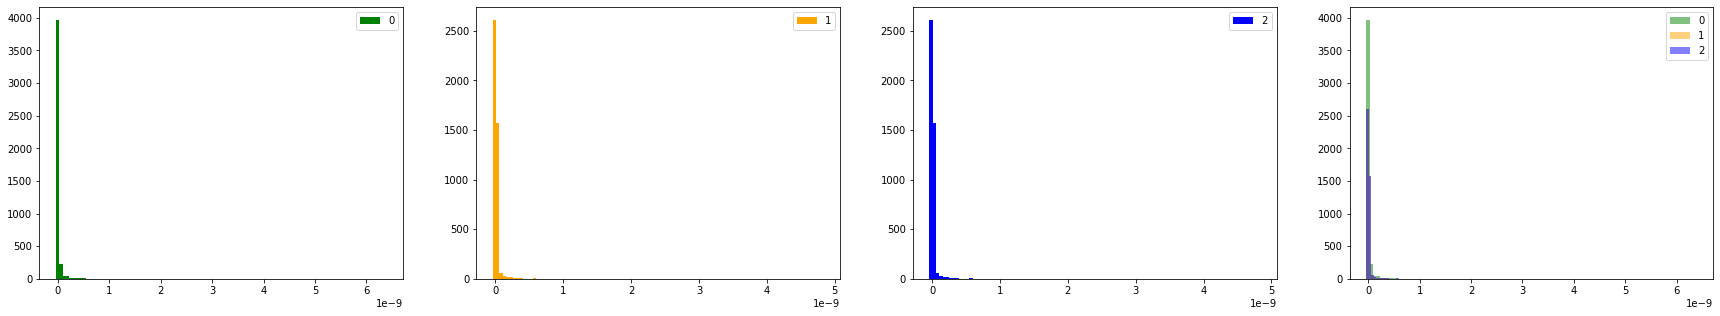

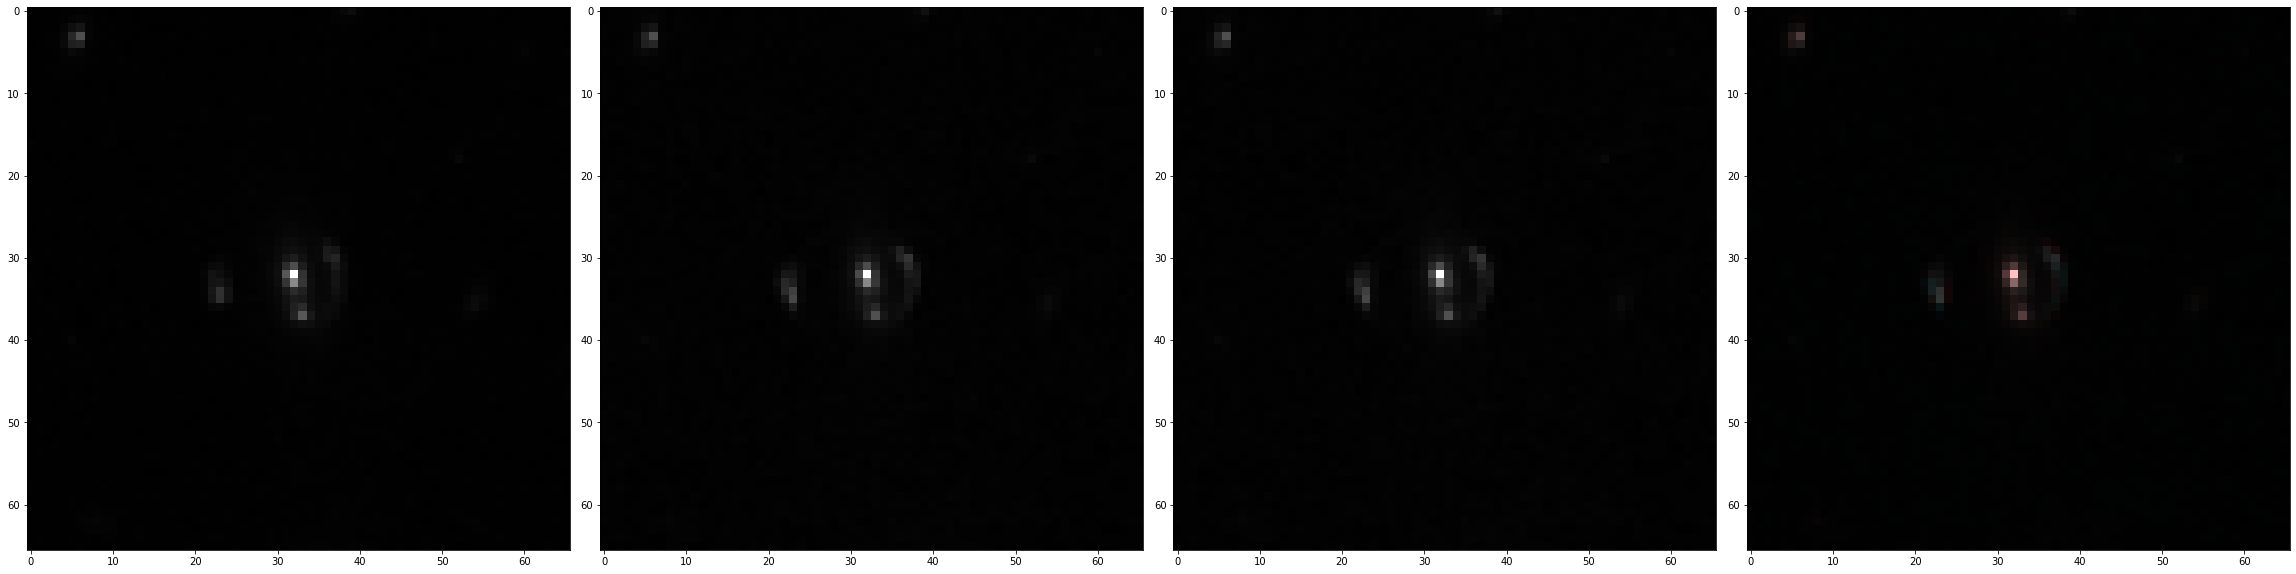

In [8]:
 
for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  img = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  img = np.array(img)
  s = img.shape

  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(30, 5))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), IMGN[:,:,i].max(), 100), color=C[i], label=str(i))
  plt.legend()
  plt.subplot(1, 4, 4)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), IMGN[:,:,i].max(), 100), color=C[i], alpha=0.5, label=str(i))
  plt.legend()

for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  img = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  img = np.array(img)
  s = img.shape
  # print(s)

  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(32, 32))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.imshow(IMGN[:,:,i], cmap=plt.cm.gray)

plt.subplot(1, 4, 4)


IMG3Channels = IMGN
# print(IMG3Channels.max(), IMG3Channels.min())

rgb = array_to_img(IMGN)
plt.imshow(rgb)
plt.tight_layout()
plt.show()






# With Contrast Image Adjust





In [9]:
def imadjust(x,a,b,c,d,gamma=1):
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y

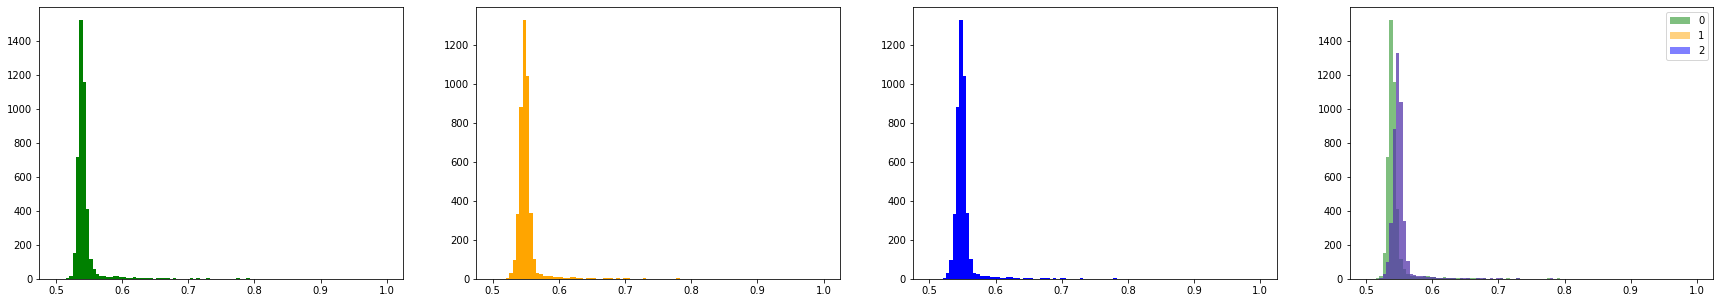

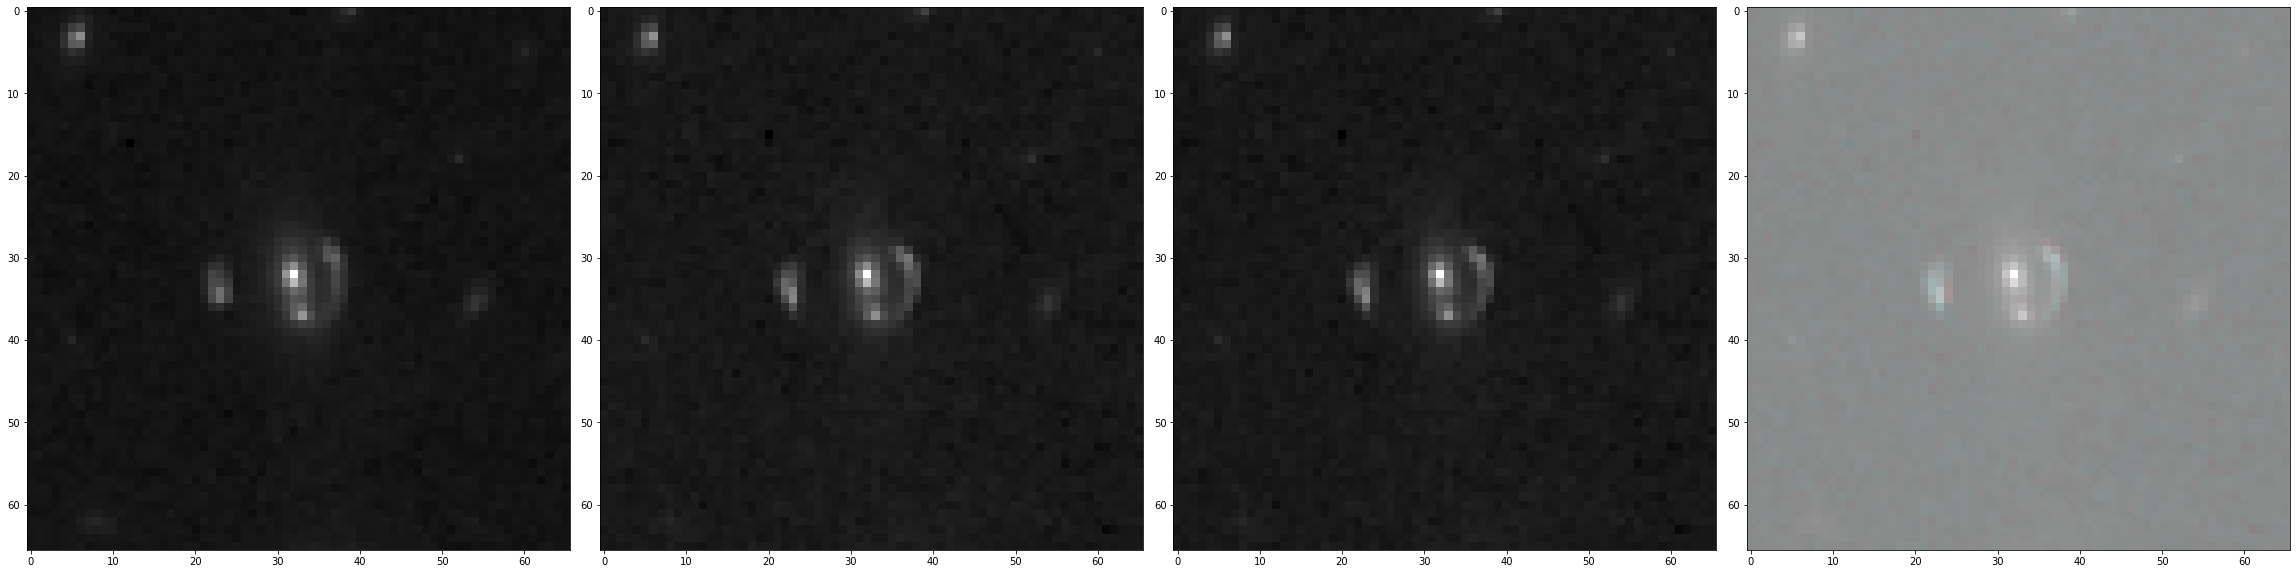

In [10]:
Max_Adjust = 1.0
Min_Adjust = 0.5
Gamma = 0.5
for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  arr = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  arr = np.array(arr)
  img=imadjust(arr,arr.min(),arr.max(),Min_Adjust,Max_Adjust, Gamma)

  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(30, 5))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), IMGN[:,:,i].max(), 100), color=C[i], label=str(i))
  plt.subplot(1, 4, 4)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), IMGN[:,:,i].max(), 100), color=C[i], alpha=0.5, label=str(i))
plt.legend()

for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  arr = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  arr = np.array(arr)
  img=imadjust(arr,arr.min(),arr.max(),Min_Adjust,Max_Adjust, Gamma)
  s = img.shape

  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(32, 32))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.imshow(IMGN[:,:,i], cmap=plt.cm.gray)


plt.subplot(1, 4, 4)
plt.imshow(IMGN, cmap=plt.cm.gray)
plt.tight_layout()
plt.show()

# Segmentation - Normalize and Binarize image data from threshold

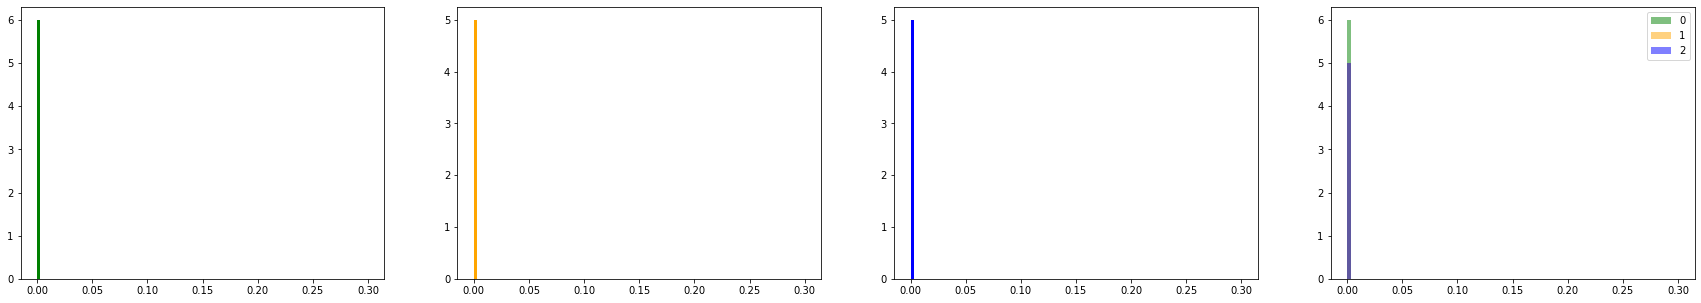

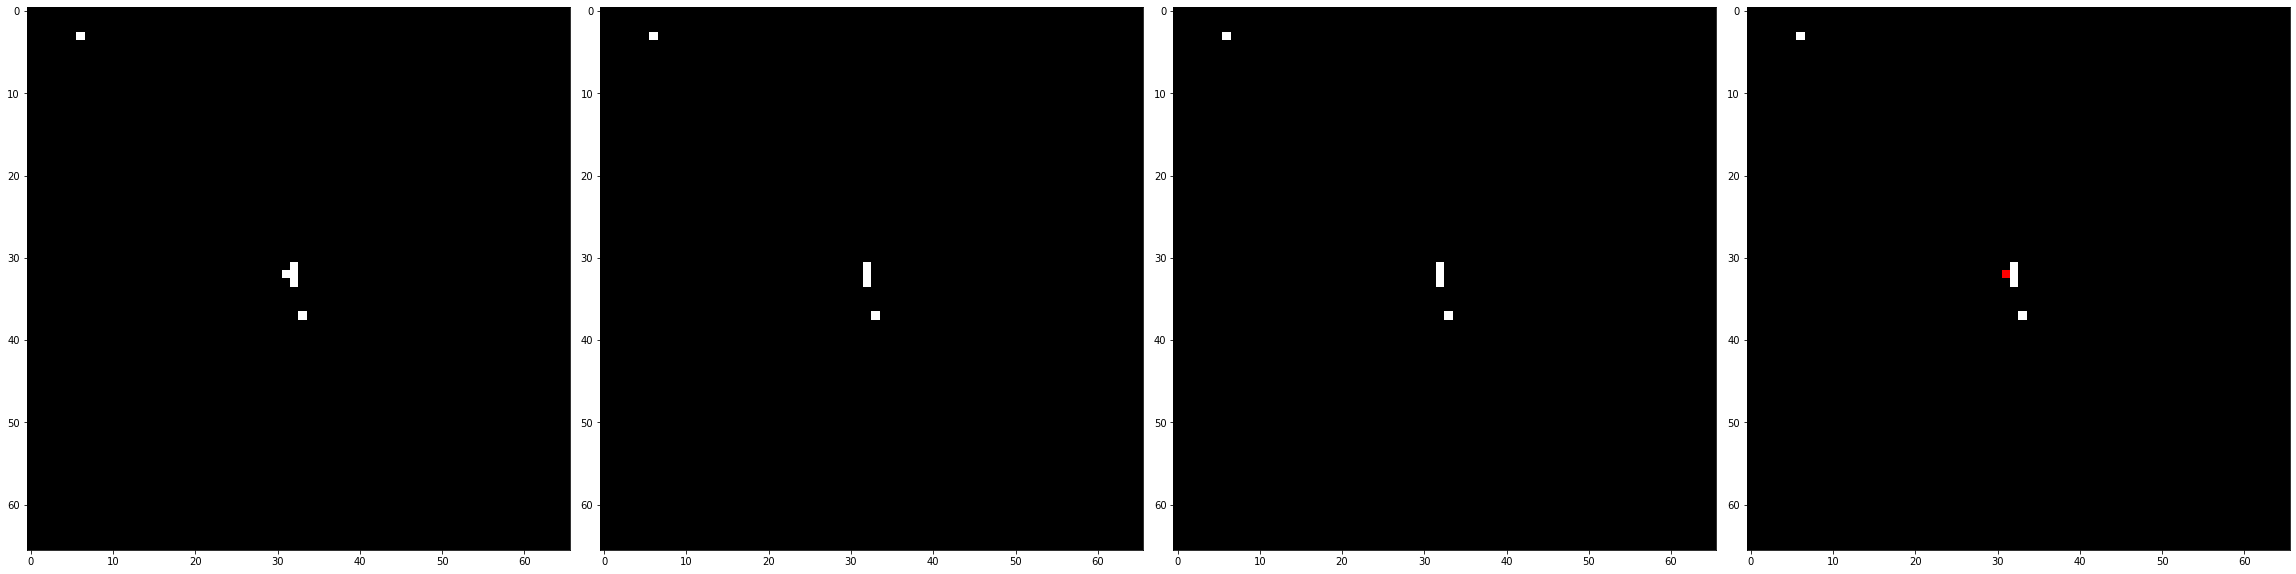

In [11]:
threshold_value = 0.3

for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  img = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  img = np.array(img)
  s = img.shape
  _max = img.max()
  _p_max = np.percentile(img, 100.0)
  _min = img.min()
  _p_min = -(np.percentile(-img, 100.0))
  imgN = (img - _p_min) / (_p_max - _p_min) # normalize
  img = (imgN < threshold_value).astype(int) # binarization from threshold
  # print(img.max(), img.min())
  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(30, 5))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), threshold_value, 100), color=C[i], label=str(i))
  plt.subplot(1, 4, 4)
  plt.hist(IMGN[:,:,i].ravel(), bins=np.linspace(IMGN[:,:,i].min(), threshold_value, 100), color=C[i], alpha=0.5, label=str(i))
plt.legend()

for i,j in enumerate(CHL):
  dirCH = "imageEUC_" + j + "-" + str(ID) + ".fits"
  img = fits.getdata(os.path.join(dirpath,dirCH), ext=0)
  img = np.array(img)
  s = img.shape
  # print(s)
  
  _max = img.max()
  _p_max = np.percentile(img, 100.0)
  _min = img.min()
  _p_min = -(np.percentile(-img, 100.0))
  imgN = (img - _p_min) / (_p_max - _p_min)
  img = (imgN > threshold_value).astype(int)

  if i == 0:
    IMGN = np.zeros((s[0],s[1], len(CHL)))
    plt.figure(figsize=(32, 32))
  # print(img.shape)
  IMGN[:,:,i] = img
  plt.subplot(1, 4, i + 1)
  plt.imshow(IMGN[:,:,i], cmap=plt.cm.gray)

plt.subplot(1, 4, 4)



rgb = array_to_img(IMGN)
plt.imshow(rgb)
plt.tight_layout()
plt.show()

# Segmentation - Maximum Entropy Method

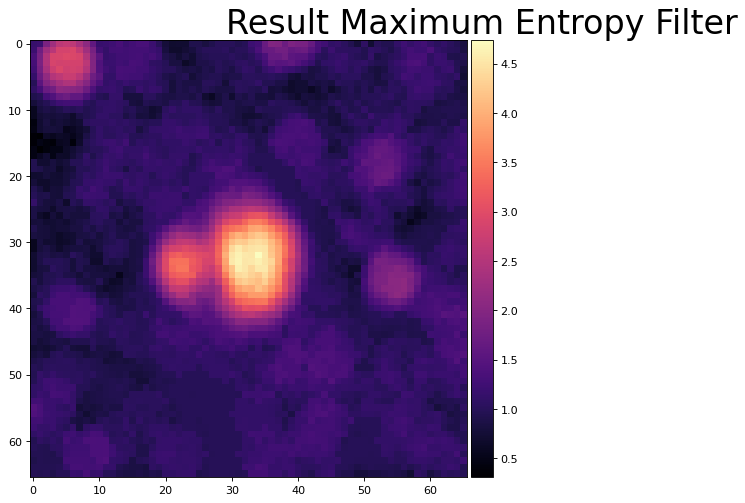

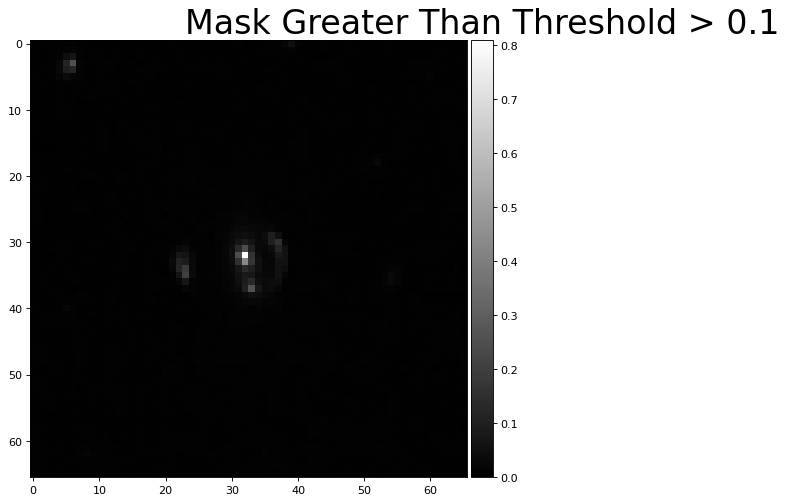

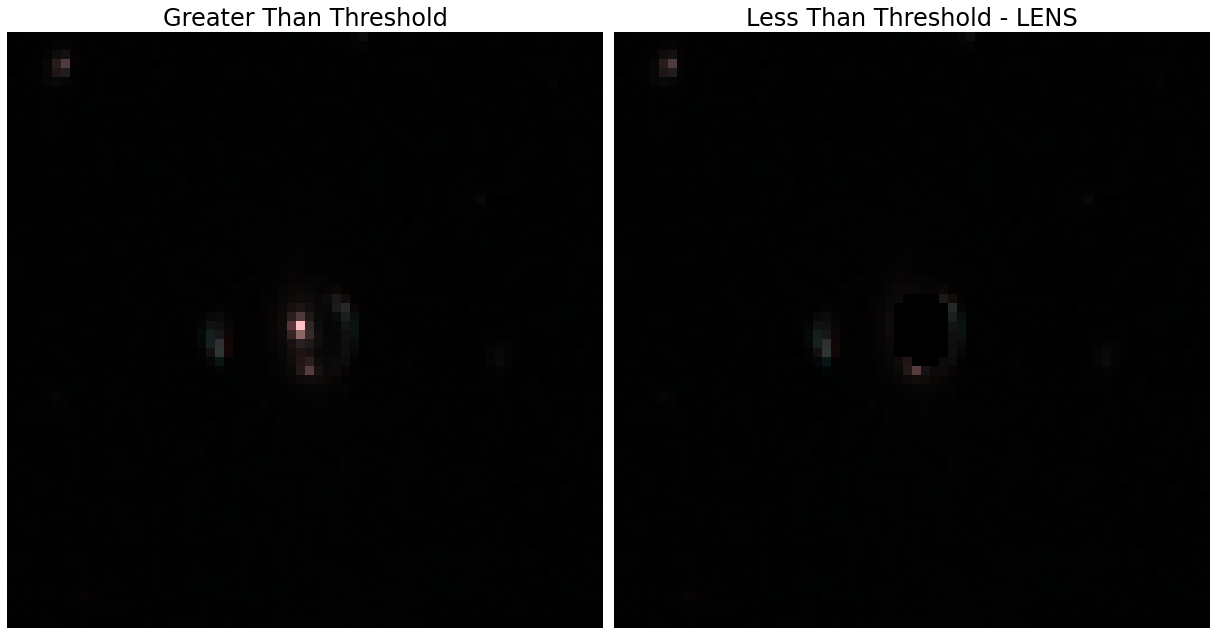

In [12]:

GTT = 0.1 # Greater Than Threshold
LTT = 0.9 # Less Than Threshold
DMT = 4 # size morphology

def disk_iterations(image):
    image_gray = rgb2gray(image)
    f_size = 20
    radi = list(range(1,10))
    fig, ax = plt.subplots(3,3,figsize=(15,15))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(f'Radius at {radi[n]}', fontsize = f_size)
        ax.imshow(entropy(shawl_gray, disk(radi[n])), cmap = 
                  'magma');
        ax.set_axis_off()
    fig.tight_layout()
    fig.title("Test Disk Interation", fontsize=50)

def threshold_checker(image, DMT):
    thresholds =  np.arange(0.1,1.1,0.1)
    image_gray = rgb2gray(image)
    entropy_image = entropy(image_gray, square(DMT))
    scaled_entropy = entropy_image / entropy_image.max()  
    fig, ax = plt.subplots(2, 5, figsize=(17, 10))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(f'Threshold  : {round(thresholds[n],2)}', 
                     fontsize = 16)
        threshold = scaled_entropy > thresholds[n]
        ax.imshow(threshold, cmap = 'gist_stern_r') ;
        ax.axis('off')
    fig.tight_layout()

def entropy_mask_viz(image):
    image_gray = rgb2gray(image)
    entropy_image = entropy(image_gray, disk(6))
    scaled_entropy = entropy_image / entropy_image.max()
    f_size = 24
    fig, ax = plt.subplots(1, 2, figsize=(17, 10))
    
    ax[0].set_title('Greater Than Threshold', 
                     fontsize = f_size)
    threshold = scaled_entropy > GTT
    image_a = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[0].imshow(image_a)
    ax[0].axis('off')
    
    ax[1].set_title('Less Than Threshold - LENS', 
                     fontsize = f_size)
    threshold = scaled_entropy < LTT
    image_b = np.dstack([image[:,:,0]*threshold,
                            image[:,:,1]*threshold,
                            image[:,:,2]*threshold])
    ax[1].imshow(image_b)
    ax[1].axis('off')
    fig.tight_layout()
    # plt.title("Lens", fontsize=30)
    return [image_a, image_b]



arr = IMG3Channels
new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
shawl_gray = rgb2gray(new_arr)


# disk_iterations(shawl_gray) # uncomment to test disks 

# threshold_checker(shawl_gray, DMT) # uncomment to test thresholds


entropy_image = entropy(shawl_gray, disk(DMT))
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(entropy_image, cmap = 'magma');
plt.title("Result Maximum Entropy Filter", fontsize=30)


scaled_entropy = shawl_gray / shawl_gray.max()
entropy_image = entropy(scaled_entropy, disk(DMT))
scaled_entropy = entropy_image / entropy_image.max()
mask = scaled_entropy > GTT
plt.figure(num=None, figsize=(8, 6), dpi=80)
imshow(shawl_gray * mask, cmap = 'gray');
plt.title("Mask Greater Than Threshold > " + str(GTT), fontsize=30)

entropic_images = entropy_mask_viz(new_arr)



# Segmentation - Kmeans

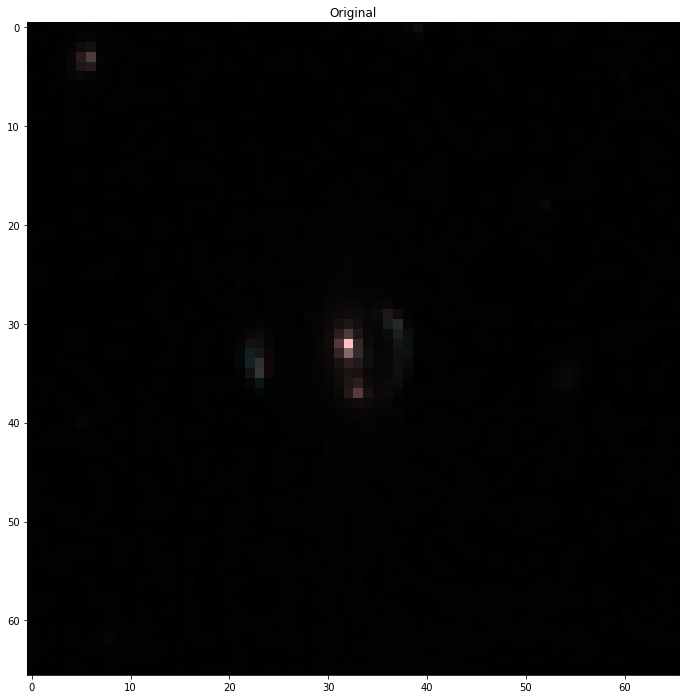

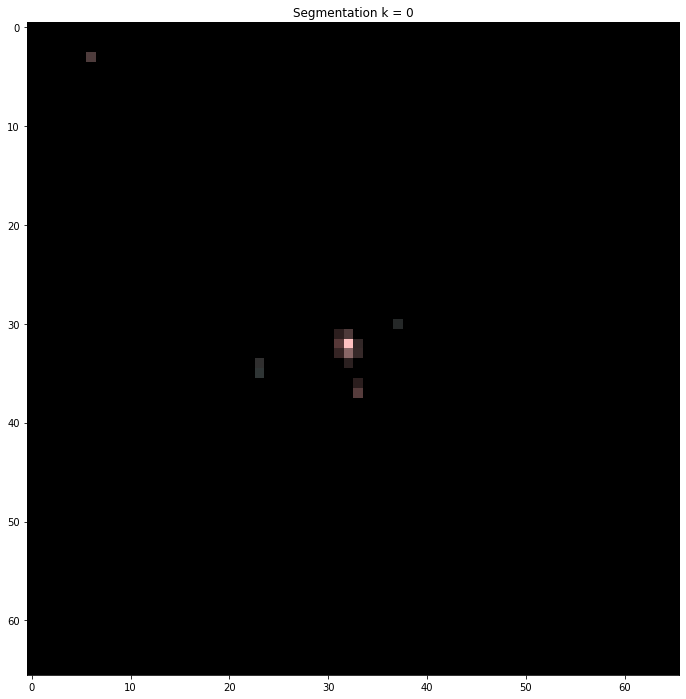

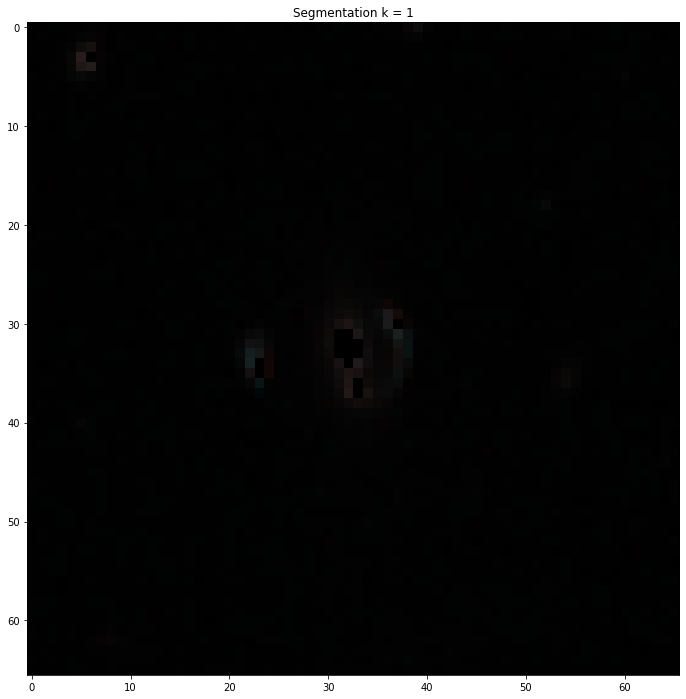

In [13]:

 
# %matplotlib inline
 
# Read in the image
image = new_arr
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.title("Original")
# print(arr.max(), arr.min())
 
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)


#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 
# then perform k-means clustering wit h number of clusters defined as 3
#also random centres are initially choosed for k-means clustering
# number of clusters (K)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]
 
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
# plt.imshow(segmented_image)
# plt.show()
 
for i in range(2):
  # disable only the cluster number 2 (turn the pixel into black)
  masked_image = np.copy(image)
  # convert to the shape of a vector of pixel values
  masked_image = masked_image.reshape((-1, 3))
  # color (i.e cluster) to disable
  cluster = i

  masked_image[labels == cluster] = [0, 0, 0]
  # convert back to original shape
  masked_image = masked_image.reshape(image.shape)
  # show the image
  plt.figure(figsize=(12, 12))
  plt.imshow(masked_image)
  plt.title("Segmentation k = " + str(i))
  plt.show()


